In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

In [2]:
import jax
import jax.numpy as jnp
import numpyro
from numpyro import infer

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

In [8]:
import antiglitch
antiglitch.utils.datadir = '/home/andrew.lundgren/src/antiglitch/notebooks/data/'
from antiglitch import freqs, extract_glitch, fsignal, to_fd, glitch_model
from antiglitch import rfft, irfft

In [9]:
if False:
    numpyro.set_host_device_count(4) # Use 4 cores if available

In [28]:
ml_key = {'tomte': 'Tomte', 'blip' : 'Blip', 'koi' : 'Koi_Fish', 'lowblip' : 'Blip_Low_Frequency'}

In [10]:
df = pd.read_json('../data/all_PE.json')

In [21]:
# Define Bayesian sampler
sampler = infer.MCMC(
    infer.NUTS(glitch_model),
    num_warmup=2000,
    num_samples=1000,
    num_chains=1,
    progress_bar=True,
)

In [12]:
key = ('L1', 'tomte', 403)
snip1 = antiglitch.Snippet(*key)
snip2 = antiglitch.Snippet(*key)

invasd = snip1.invasd
fglitch = to_fd(snip1.whts)

/nfshome/store01/users/andrew.lundgren/src/antiglitch/antiglitch/utils.py:31: RuntimeWarning: divide by zero encountered in power
  invasd = ((4096.*npz['psd'])**-0.5)[:4097]


In [22]:
sampler.run(jax.random.PRNGKey(0), freqs = freqs[1:], invasd = invasd[1:], data=fglitch[1:])

sample: 100%|██████████| 3000/3000 [00:17<00:00, 169.53it/s, 31 steps of size 9.00e-02. acc. prob=0.94] 


In [24]:
itrace = az.from_numpyro(sampler)
summ = az.summary(itrace, kind='stats')
inf_data = itrace
inf = {key: float(np.mean(inf_data.posterior[key]))
        for key in ['amp_r', 'amp_i', 'f0','gbw','time']}
cpamp = inf['amp_r']+1.j*inf['amp_i']
inf['amp'] = np.abs(cpamp)
inf['phase'] = np.angle(cpamp)

In [34]:
inf

{'amp_r': 1.717441439628601,
 'amp_i': -5.155041694641113,
 'f0': 169.79547119140625,
 'gbw': 0.49706146121025085,
 'time': -0.4311378300189972,
 'amp': 5.433604694127268,
 'phase': -1.2492039196534348}

In [41]:
df.query(f"ifo == '{key[0]}' and ml_label == '{ml_key[key[1]]}' and num == {key[2]}")

,amp_r,amp_i,frequency,gbw,time,amp_r_sd,amp_i_sd,f0_sd,gbw_sd,time_sd,amp,phase,snr,power,residual,peak_frequency,ifo,ml_label,num
1980,1.612,-4.966,171.776,0.492,-0.431,1.098,1.135,83.468,0.27,0.0,5.221082,-1.25692,5.23971,1.567764,1.56787,226.170625,L1,Tomte,403


In [25]:
snip1.set_infer(inf)
snip2.set_infer(f"ifo == {key[0]} and ml_label == {ml_key[key[1]]} and num == {key[2]}"

NameError: name 'pkl_to_infer' is not defined

array([[<AxesSubplot: title={'center': 'amp_i'}>,
        <AxesSubplot: title={'center': 'amp_r'}>,
        <AxesSubplot: title={'center': 'f0'}>],
       [<AxesSubplot: title={'center': 'gbw'}>,
        <AxesSubplot: title={'center': 'time'}>, <AxesSubplot: >]],
      dtype=object)

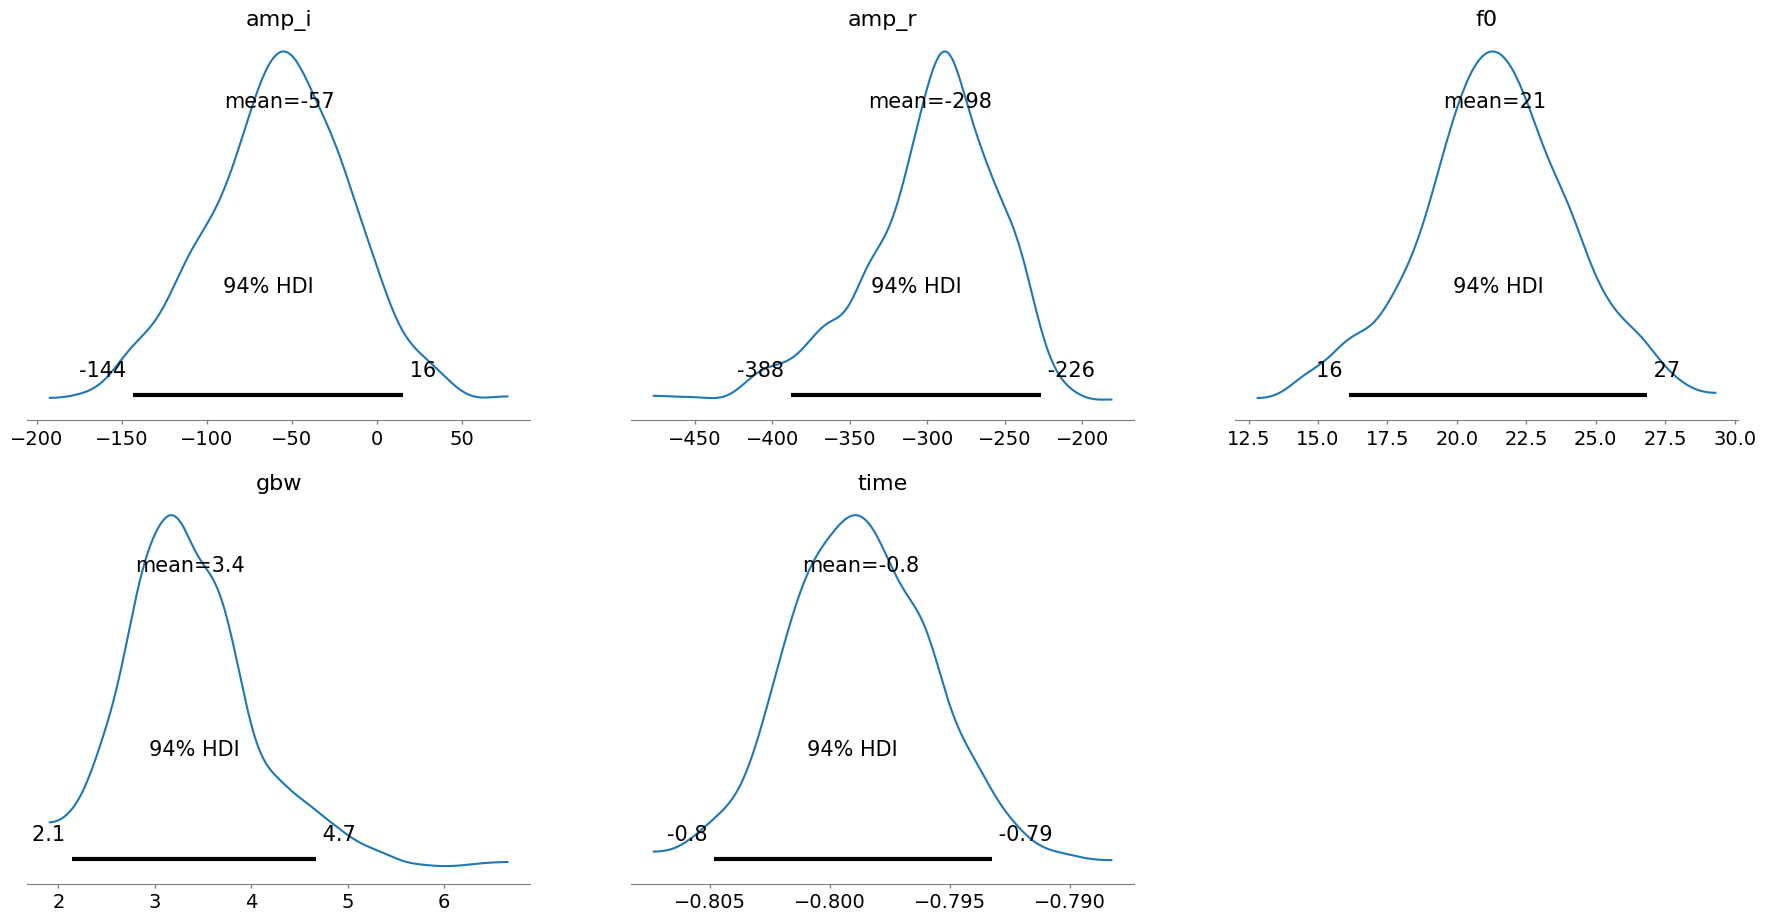

In [40]:
az.plot_posterior(itrace)

In [47]:
pkl[key]

,mean,sd,hdi_3%,hdi_97%
amp_i,-4.966,1.135,-7.087,-3.054
amp_r,1.612,1.098,-0.439,3.664
f0,171.776,83.468,33.078,331.640
gbw,0.492,0.270,0.250,0.960
time,-0.431,0.000,-0.432,-0.430


In [42]:
summ

,mean,sd,hdi_3%,hdi_97%
amp_i,-57.143,41.907,-143.538,15.776
amp_r,-298.339,44.271,-388.275,-226.382
f0,21.378,2.759,16.116,26.848
gbw,3.369,0.680,2.137,4.673
time,-0.799,0.003,-0.805,-0.793


(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

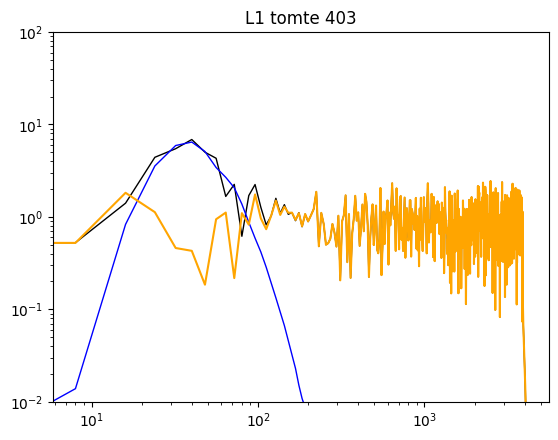

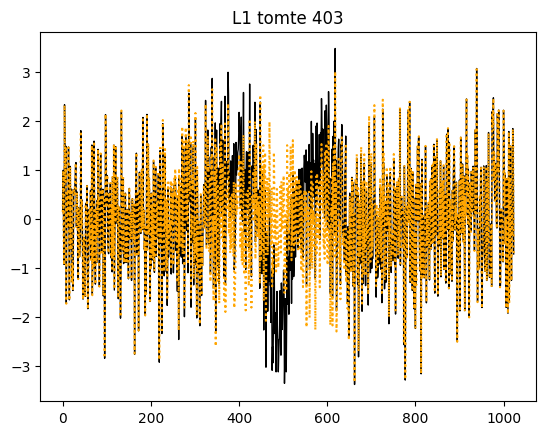

In [43]:
snip1.plot()

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

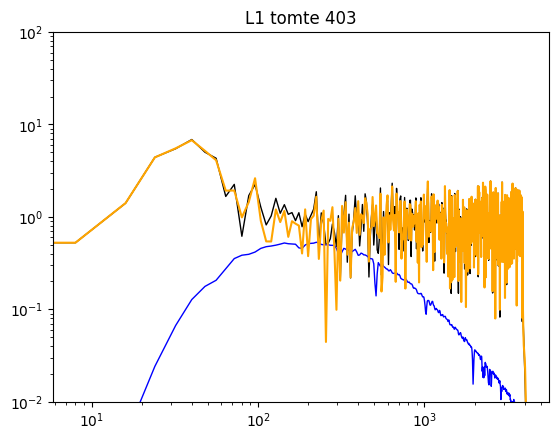

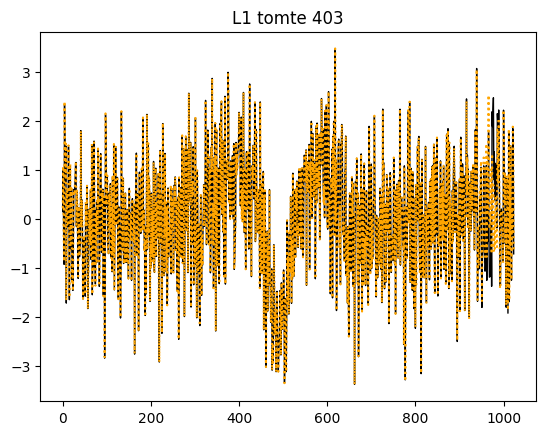

In [44]:
snip2.plot()

In [82]:
summ

,mean,sd,hdi_3%,hdi_97%
amp_i,897.323,111.298,698.108,1122.942
amp_r,184.492,110.621,-35.126,372.492
f0,18.882,2.051,14.974,22.630
gbw,2.756,0.452,1.942,3.576
time,0.009,0.003,0.005,0.014


In [46]:
pkl_to_infer(pkl[key])

{'amp_r': -1159.109,
 'amp_i': 74.605,
 'f0': 15.775,
 'gbw': 1.418,
 'time': -0.797}

In [14]:
glitch1 = fsignal(freqs, 14., 0.78)

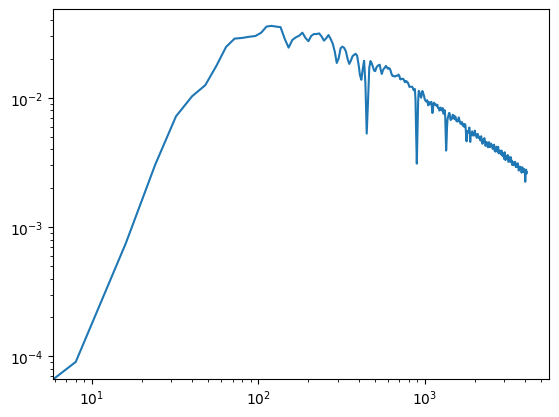

In [12]:
plt.loglog(freqs, invasd)

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

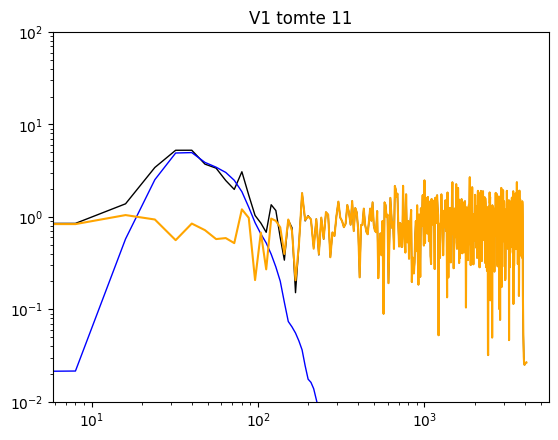

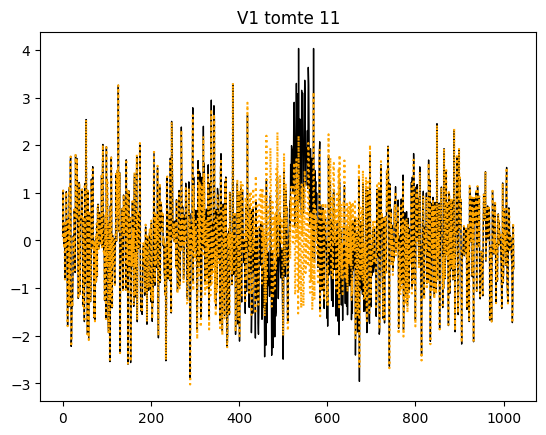

In [22]:
snip.set_infer(inf)


In [13]:
# An attempt at finding the MAP

num_svi_steps = 2000
from numpyro.infer import SVI, Trace_ELBO, autoguide
optimizer = numpyro.optim.Adam(step_size=1e-3)
guide = autoguide.AutoDelta(glitch_model)
svi = SVI(glitch_model, guide, optimizer, loss=Trace_ELBO())
svi_result = svi.run(jax.random.PRNGKey(0), num_svi_steps, freqs[1:], invasd[1:], data=fglitch[1:])
params, losses = svi_result.params, svi_result.losses

100%|██████████| 2000/2000 [00:01<00:00, 1047.41it/s, init loss: 4112.2671, avg. loss [1901-2000]: 1895.7081]


In [4]:
jax.__file__

'/home/andrew.lundgren/.conda/envs/jax/lib/python3.9/site-packages/jax/__init__.py'

In [ ]:
def test(x, *args, **kwargs):
    print(x)
    print(args)
    print(kwargs)

In [ ]:
test(0, 1, 2, a = 3, b = 4)